<a href="https://colab.research.google.com/github/ravikarora/Orangewood_Task/blob/main/Edge_AI_Development_Implement_a_Pre_trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge AI Development: Implement a Pre-trained Model
**Task: Use a pre-trained AI model (like MobileNet for image classification) to analyze and classify a small set of images.**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
!apt install file
!apt install -y imagemagick
!file /root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.199.jpg
!identify /root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.199.jpg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
file is already the newest version (1:5.38-4).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 liblqr-1-0
  libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra libmagickwand-6.q16-6
  libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch inkscape libjxr-tools li

**Load train and validation dataset**


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


As the original dataset doesn’t contain a test set,  will create one.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Data augmentation and preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create base model
We will use MobileNetV2, which performs well on mobile devices. We will pass training images to base model and get features output by base model.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9406464/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

# Setup model architecture

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# Chain the layers

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train the model**

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 75s 1s/step - loss: 0.6938 - accuracy: 0.5940 - val_loss: 0.4647 - val_accuracy: 0.7748
Epoch 2/10
63/63 [==============================] - 68s 1s/step - loss: 0.5481 - accuracy: 0.7000 - val_loss: 0.3643 - val_accuracy: 0.8428
Epoch 3/10
63/63 [==============================] - 64s 1s/step - loss: 0.4819 - accuracy: 0.7455 - val_loss: 0.2939 - val_accuracy: 0.8911
Epoch 4/10
63/63 [==============================] - 68s 1s/step - loss: 0.4350 - accuracy: 0.7900 - val_loss: 0.2522 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 67s 1s/step - loss: 0.3993 - accuracy: 0.8125 - val_loss: 0.2241 - val_accuracy: 0.9295
Epoch 6/10
63/63 [==============================] - 88s 1s/step - loss: 0.3632 - accuracy: 0.8200 - val_loss: 0.2033 - val_accuracy: 0.9307
Epoch 7/10
63/63 [==============================] - 69s 1s/step - loss: 0.3642 - accuracy: 0.8290 - val_loss: 0.1887 - val_accuracy: 0.9431
Epoch 8/10
63/63 [==

# Fine tuning
**Un-freeze the top layers of the model**


In [ ]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

**Compile the model**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

**Train the model**

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 107s 2s/step - loss: 0.2435 - accuracy: 0.8890 - val_loss: 0.1035 - val_accuracy: 0.9666
Epoch 11/20
63/63 [==============================] - 97s 2s/step - loss: 0.1957 - accuracy: 0.9190 - val_loss: 0.0686 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 105s 2s/step - loss: 0.1927 - accuracy: 0.9230 - val_loss: 0.0621 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 99s 2s/step - loss: 0.1758 - accuracy: 0.9260 - val_loss: 0.0627 - val_accuracy: 0.9752
Epoch 14/20
63/63 [==============================] - 101s 2s/step - loss: 0.1552 - accuracy: 0.9370 - val_loss: 0.0507 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 97s 2s/step - loss: 0.1408 - accuracy: 0.9435 - val_loss: 0.0562 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 100s 2s/step - loss: 0.1476 - accuracy: 0.9390 - val_loss: 0.0477 - val_accuracy: 0.9839
Epoch 17/

# Prediction

Predictions:
 [0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1]
Labels:
 [0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1]


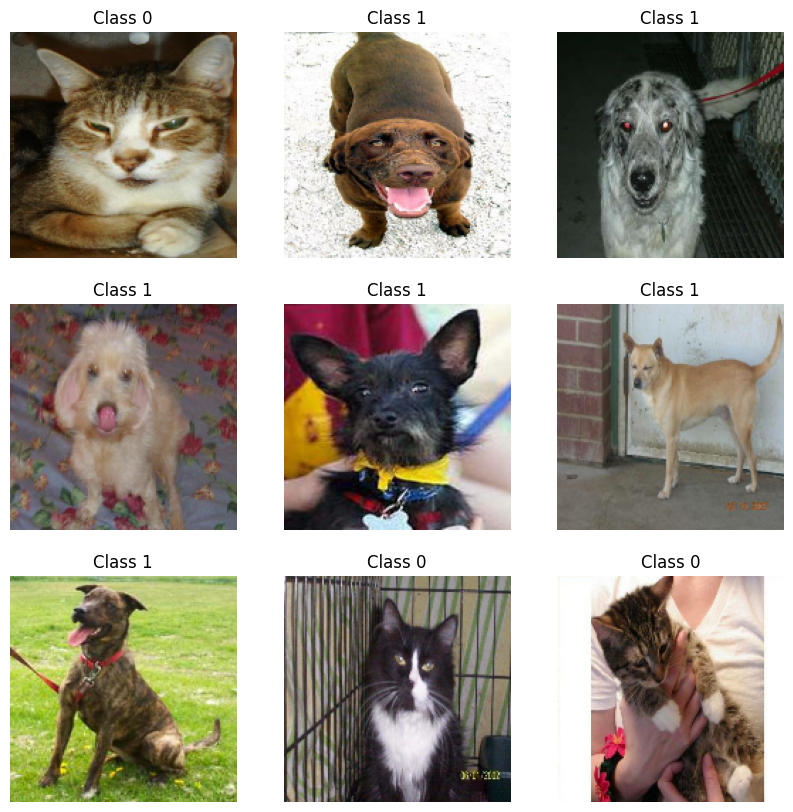

In [ ]:
class_names = ['Class 0', 'Class 1', 'Class 2', ...]
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
